# 0. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras.backend as K
from tensorflow.keras import layers, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, silhouette_samples, silhouette_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor, kneighbors_graph
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
import os
import matplotlib.image as mpimg
from tabulate import tabulate
import json
from datetime import datetime
import uuid

# 1. Training with unsw Data set

In [2]:
from data_preperation import data_preperation

## 1.1 feature analysis with data preparation

In [3]:
feature_analysis = False
normalisation = 1
EPOCH = 100



dataframe info
<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int

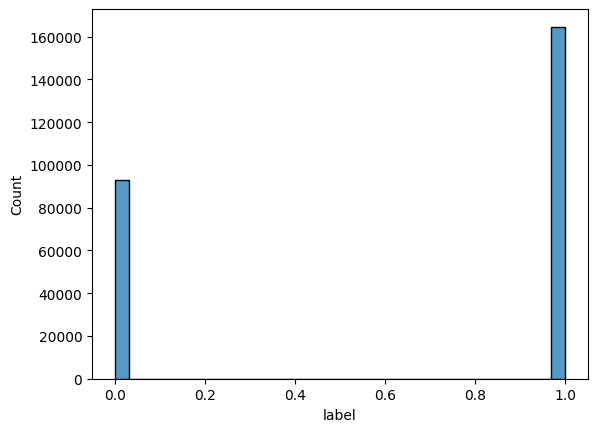

In [4]:
raw_data, dataframe = data_preperation(feature_analysis=feature_analysis)

## 1.2 Data normalisation and seperation

In [5]:
from data_normalisation import data_normalisation

In [6]:
normal_train_data_wl_normalized, normal_test_data_wl_normalized, anomalous_train_data_wl_normalized, anomalous_test_data_wl_normalized,normal_test_data_labels = data_normalisation(raw_data,normalisation=normalisation)


train_data : 206138
test_data : 51535
normal train_data : 131784
normal_test_data : 32889
anormalous train_data : 74354
anormalous test_data : 18646
normalisation StandardScaler 


In [7]:
normal_train_data_wl_normalized[2]

<tf.Tensor: shape=(43,), dtype=float32, numpy=
array([-0.1658435 ,  0.13069965,  1.5554063 , -1.1410627 , -0.03295999,
        0.0141241 , -0.04721084,  0.00357784, -0.73962885, -2.517334  ,
        1.3866818 , -0.4965534 ,  1.7000273 , -0.03666673,  0.00576558,
       -0.07054967, -0.07671408, -0.0758711 ,  0.59483695,  1.3905696 ,
        2.7635574 ,  0.69365525,  1.3906165 ,  0.13396937, -0.38676974,
        0.66426075, -0.2303352 ,  3.1559005 ,  1.6640474 ,  0.04204936,
       -0.83999753, -1.0987834 , -0.68065196, -0.6503299 , -0.6977447 ,
       -0.6192628 , -0.10507276, -0.10507276,  1.2573265 , -0.7601173 ,
       -0.813821  ,  0.        , -0.7026869 ], dtype=float32)>

In [8]:
print(normal_train_data_wl_normalized.shape[1])

43


## 1.3 Method to plot and save data instance

In [9]:
def plot_instance(range, normal_data_instance, anomalious_data_instance, title, data_instance ):
    os.makedirs(data_instance, exist_ok=True)
     # Generate filenames based on the titles
    normal_filename = "normal_plot_of_normal_data_instance_feature_analysis_{}_normalisation_{}.png".format(feature_analysis, normalisation)
    anomalous_filename = "anomalous_plot_of_anomalous_data_instance_feature_analysis_{}_normalisation_{}.png".format(feature_analysis, normalisation)
    
    plt.grid()
    plt.plot(np.arange(range), normal_data_instance[0])
    plt.title("A plot of normal data instance (Feature Analysis: {}, Normalisation: {})".format(feature_analysis, normalisation))
    plt.savefig(os.path.join(data_instance, normal_filename))
    plt.close()
    
    plt.grid()
    plt.plot(np.arange(range), anomalious_data_instance[0])
    plt.title("A plot of anomalous data instance (Feature Analysis: {}, Normalisation: {})".format(feature_analysis, normalisation))
    plt.savefig(os.path.join(data_instance, anomalous_filename))
    plt.close()

In [10]:

def plot_images_in_folder(folder_path, images_per_row=3):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    num_images = len(image_files)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5*num_rows))
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = mpimg.imread(image_path)
        
        ax = axes[i // images_per_row, i % images_per_row] if num_rows > 1 else axes[i % images_per_row]
        ax.imshow(image)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()



In [11]:
plot_instance(normal_train_data_wl_normalized.shape[1], normal_train_data_wl_normalized,anomalous_train_data_wl_normalized,"title","data_instance")

## 1.4 Result plots for all types of normalisation

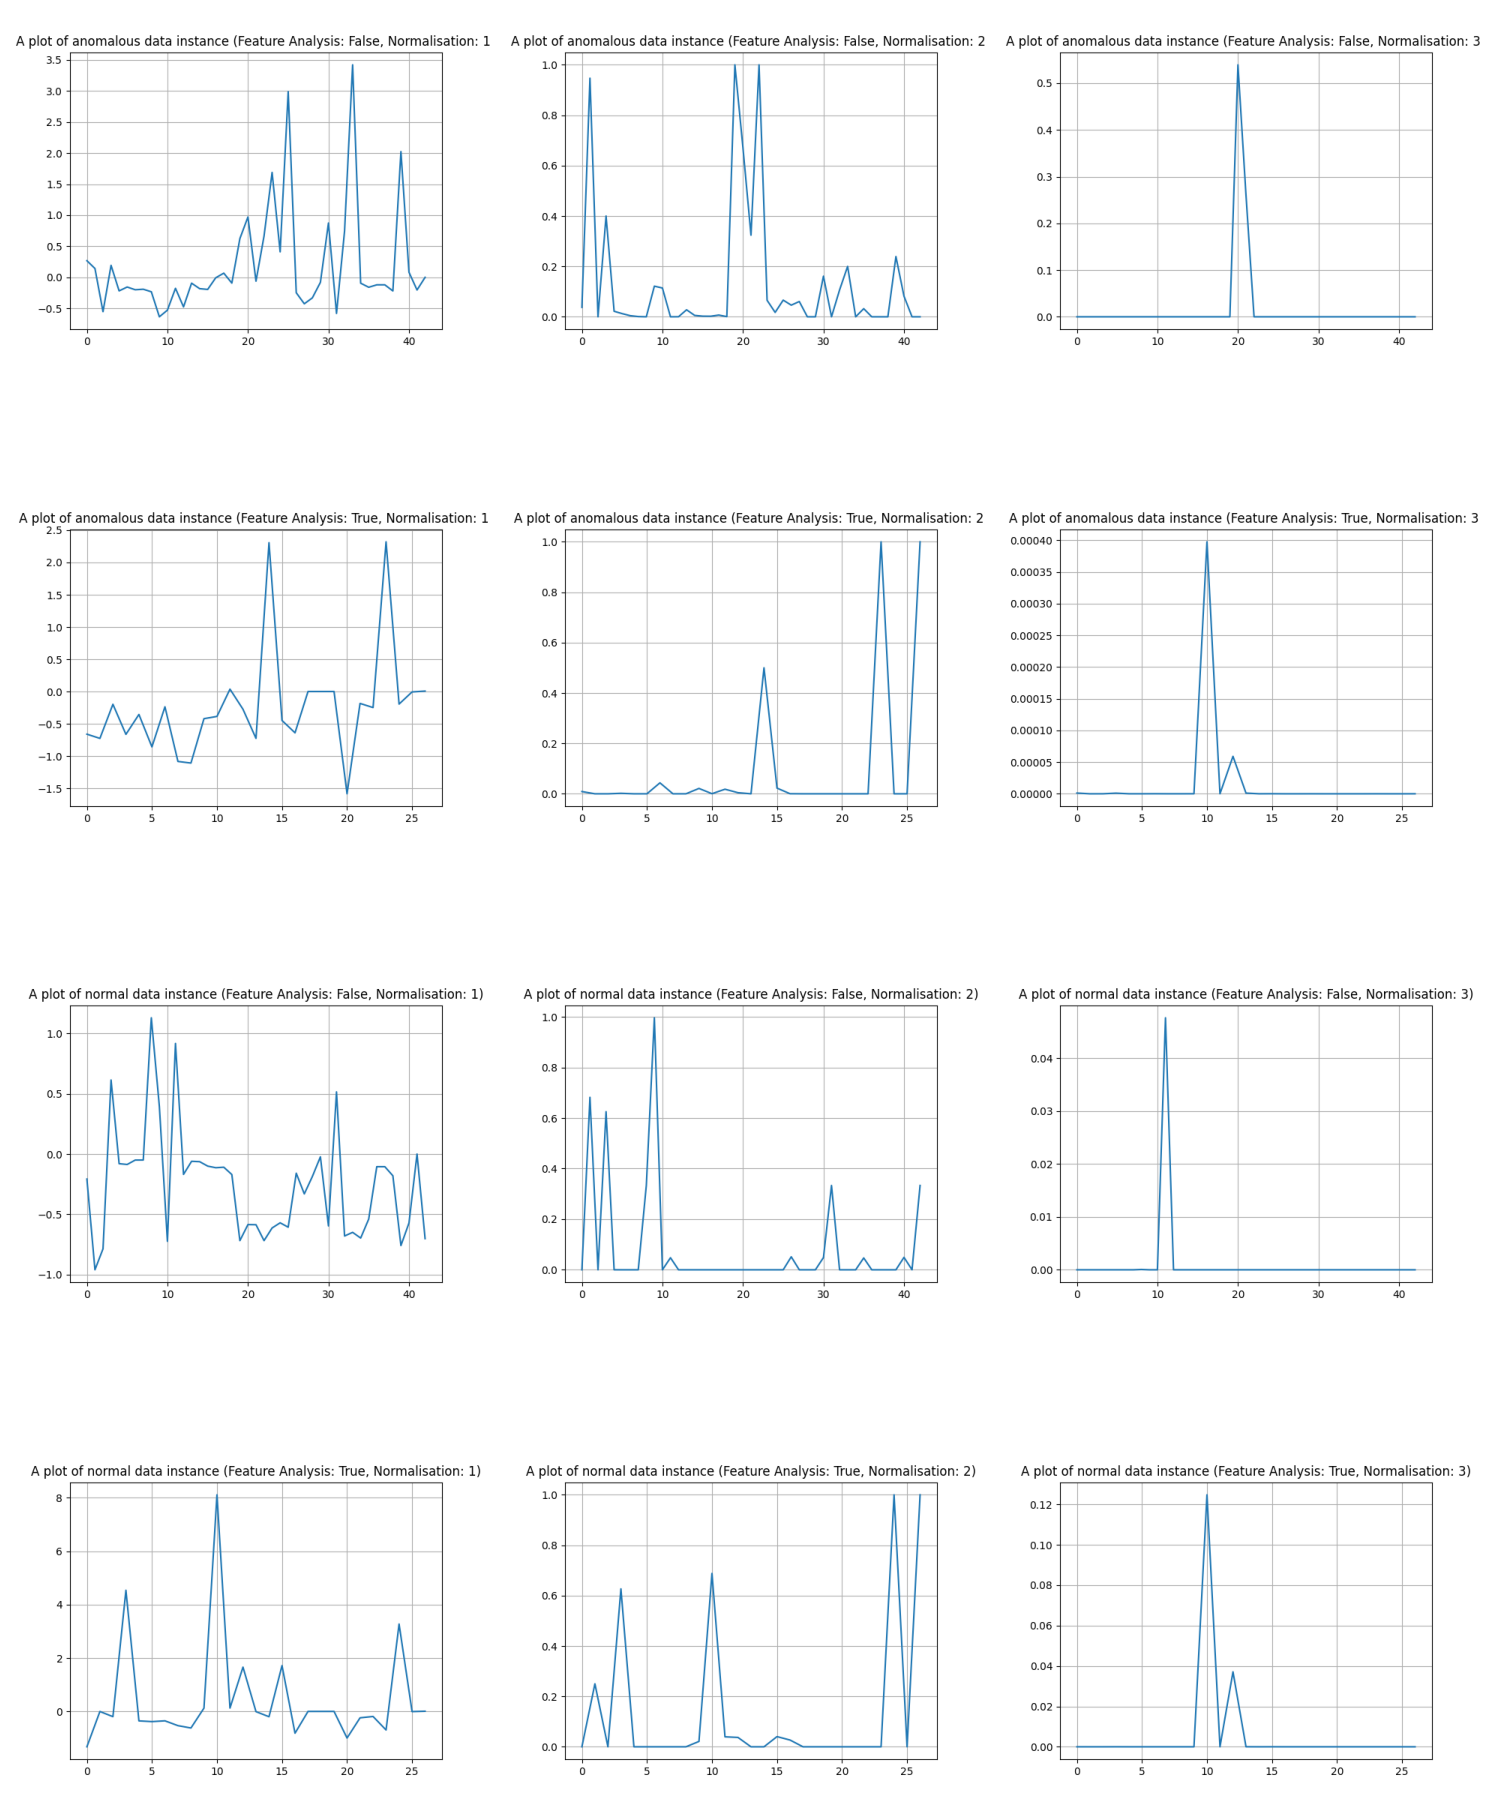

In [12]:
plot_images_in_folder('data_instance', images_per_row=3)

## 1.5 method for creating and saving normal and anormal sample reconstruction 

In [13]:
def reconstruct_sample(model, range, normal_data_instance, anomalous_data_instance, reconstruct_sample, feature_analysis, normalisation):
    os.makedirs(reconstruct_sample, exist_ok=True)
    autoencoder_name = model.name
    # Construct the filename
    filename_normal = "{}_featureanalysis_{}_normalisation_{}_normal.png".format(autoencoder_name, feature_analysis, normalisation)
    filename_anomalous = "{}_featureanalysis_{}_normalisation_{}_anomalous.png".format(autoencoder_name, feature_analysis, normalisation)

    encoded_data = model.encoder(normal_data_instance).numpy()
    decoded_data = model.decoder(encoded_data).numpy()
    # Normal test sample
    plt.plot(normal_data_instance[4], 'b')
    plt.plot(decoded_data[4], 'r')
    plt.fill_between(np.arange(range), decoded_data[1], normal_data_instance[1], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.title(filename_normal)  # Set the title to the filename
    plt.savefig(os.path.join(reconstruct_sample, filename_normal))
    plt.close()
    
    encoded_data = model.encoder(anomalous_data_instance).numpy()
    decoded_data = model.decoder(encoded_data).numpy()
    # Anomaly data sample
    plt.plot(anomalous_data_instance[4], 'b')
    plt.plot(decoded_data[4], 'r')
    plt.fill_between(np.arange(range), decoded_data[1], anomalous_data_instance[1], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.title(filename_anomalous)  # Set the title to the filename
    plt.savefig(os.path.join(reconstruct_sample, filename_anomalous))
    plt.close()


In [14]:
runs_data = {}


# Function to add run statistics to a JSON file
def add_run_stats_to_file(model_name, predictions, labels, feature_analysis, normalization, folder_path):
    accuracy = accuracy_score(labels, predictions)
    
     # Check if labels are multilabel
    if labels.ndim > 1 and labels.shape[1] > 1:
        # Use micro averaging strategy for multilabel
        average = 'micro'
    else:
        # Use default averaging strategy for non-multilabel
        average = 'binary'  
        
    precision = precision_score(labels, predictions, average=average)
    recall = recall_score(labels, predictions, average=average)
    
    timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    unique_id = str(uuid.uuid4())[:8]  # Generate a unique identifier
    filename = f"featureanalysis_{feature_analysis}_normalization_{normalization}.json"
    
    run_stats = {
        f"Run_{timestamp}_{unique_id}": [{
            "Model": model_name,
            "Feature Analysis": feature_analysis,
            "Normalization": normalization,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall
        }]
    }
    
    folder_path = folder_path
    os.makedirs(folder_path, exist_ok=True)
    
    file_path = os.path.join(folder_path, filename)
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            existing_stats = json.load(f)
        existing_stats.update(run_stats)
        run_stats = existing_stats
    
    with open(file_path, 'w') as f:
        json.dump(run_stats, f, indent=4)

## 1.6 method to reconstruction timeseries data 

In [15]:
def reconstruct_data(model, normal_test_data_instance, anormalous_test_data_instance):
    reconstructions_normal = model.predict(normal_test_data_instance)
    reconstructions_anomalous = model.predict(anormalous_test_data_instance)
    
    errors_normal = np.mean(np.abs(reconstructions_normal - normal_test_data_instance), axis=1)
    errors_anomalous = np.mean(np.abs(reconstructions_anomalous - anormalous_test_data_instance), axis=1)
    
    sns.histplot(errors_normal, label='Normal', kde=True, color='blue')
    sns.histplot(errors_anomalous, label='Anomalous', kde=True, color='red')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print()
    reconstructions = model.predict(normal_test_data_instance)
    train_loss = tf.keras.losses.mae(reconstructions, normal_test_data_instance)
    threshold = np.mean(train_loss) + np.std(train_loss)
    
    plt.hist(train_loss[None,:], bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()

    
    # 
    reconstructions = model.predict(anormalous_test_data_instance)
    test_loss = tf.keras.losses.mae(reconstructions, anormalous_test_data_instance)
    
    print()
    plt.hist(test_loss[None, :], bins=50)
    plt.xlabel("Test loss")
    plt.ylabel("No of examples")
    # Add a vertical line at the threshold value
    plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    
    plt.legend()
    plt.show()
    
    print("Threshold: ", threshold)
    return threshold

## 1.7 method to train all models

In [16]:
def train_model(model, train_data, test_data):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True)
    
    history = model.fit(
        train_data,
        train_data,
        epochs=EPOCH,
        batch_size=1024,
        validation_data=(test_data, test_data),
        shuffle=True,
        callbacks=[early_stopping])
    return history

## 1.8 method for anomaliy checks

In [17]:
def predict_anomaly(model, data_instance, threshold):
    data_instance = tf.expand_dims(data_instance, axis=0)

    reconstructed_instance = model(data_instance)

    mse_loss = tf.reduce_mean(tf.square(data_instance - reconstructed_instance))

    if mse_loss > threshold:
        result = "Anomaly"
    else:
        result = "Normal"

    return result

In [18]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

## 1.9 method to display model stats 

In [19]:
def display_stats_table(folder_path):
    folder_path = folder_path
    files = os.listdir(folder_path)
    
    all_stats = []
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as f:
            stats = json.load(f)
        for run_stats in stats.values():
            all_stats.extend(run_stats)
    
    headers = ["Model", "Feature Analysis", "Normalization", "Accuracy", "Precision", "Recall"]
    table = [[
        stat["Model"],
        stat["Feature Analysis"],
        stat["Normalization"],
        stat["Accuracy"],
        stat["Precision"],
        stat["Recall"]
    ] for stat in all_stats]
    
    print(tabulate(table, headers=headers, tablefmt="grid"))

## 1.10 Training curve

In [20]:
def plot_training_curve(history, autoencoder, feature_analysis, normalisation, epoch, directory):
    autoencoder_name = autoencoder.name
    directory = directory
    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Construct the filename based on the parameters
    filename = "{}_featureanalysis_{}_normalisation_{}_epoch_{}.png".format(autoencoder_name, feature_analysis, normalisation, epoch)
    
    # Plot training curve and save the image
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title(filename)

    plt.savefig(os.path.join(directory, filename))
    plt.close()

## 1.11 unsupervised Contractive Autoencoder implementation

In [20]:

class ContractiveAnomalyDetector(tf.keras.Model):
    def __init__(self, lam=1e-8 ): 
        super(ContractiveAnomalyDetector, self).__init__(name='contractive_anomaly_detector')
        self.encoder = tf.keras.Sequential([
            layers.Dense(normal_train_data_wl_normalized.shape[1], activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(64, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(8, activation="relu"),
            layers.BatchNormalization()])

        self.decoder = tf.keras.Sequential([
            layers.Dense(8, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(64, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(normal_train_data_wl_normalized.shape[1], activation="sigmoid")])

        self.lam = lam  # Regularization strength

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def compute_jacobian(self, x):
        x = tf.convert_to_tensor(x)  
    
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            encoded = self.encoder(x)
    
        jacobian = tape.jacobian(encoded, x)
        
        return jacobian

    
    def contractive_loss(self, x, x_hat, jacobian):
        mse_loss = tf.reduce_mean(tf.square(x - x_hat))
        squared_jacobian = tf.square(jacobian)
        frobenius_norm = tf.sqrt(tf.reduce_sum(squared_jacobian))        
        # Combine the losses
        total_loss = mse_loss + self.lam * frobenius_norm # + self.constant_valu
        return total_loss       

  

In [21]:
    def train_step(self, data):
        x, _ = data
        with tf.GradientTape() as tape:
            x_hat = self(x)
            jacobian = self.compute_jacobian(x)
            loss = self.contractive_loss(x, x_hat, jacobian)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)        
        self.optimizer.apply_gradients(zip(clipped_gradients, self.trainable_variables))

        return {"loss": loss}
# The compute_jacobian method calculates the Jacobian matrix of the encoded representation with respect to the input.

# The contractive_loss method computes the contractive loss, which is a combination of the mean squared error (MSE) reconstruction loss and the Frobenius norm of the Jacobian matrix.

# The train_step method is overridden to include the contractive loss during training.


In [22]:
contractive_autoencoder = ContractiveAnomalyDetector()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.09,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

contractive_autoencoder.compile(optimizer=optimizer, loss='mse')

In [23]:
contractive_autoencoder.build(input_shape = (None, normal_train_data_wl_normalized.shape[1]))
contractive_autoencoder.summary()


Model: "contractive_anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 8104      
                                                                 
 sequential_1 (Sequential)   (None, 43)                6147      
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 13685 (53.46 KB)
Non-trainable params: 566 (2.21 KB)
_________________________________________________________________


In [24]:
history = train_model(contractive_autoencoder, normal_train_data_wl_normalized, normal_test_data_wl_normalized)

Epoch 1/100

129/129 [==============================] - 8s 17ms/step - loss: 0.9376 - val_loss: 0.9008
Epoch 2/100
129/129 [==============================] - 2s 13ms/step - loss: 0.7478 - val_loss: 0.7427
Epoch 3/100
129/129 [==============================] - 2s 13ms/step - loss: 0.7103 - val_loss: 0.7081
Epoch 4/100
129/129 [==============================] - 2s 13ms/step - loss: 0.6915 - val_loss: 0.6923
Epoch 5/100
129/129 [==============================] - 2s 14ms/step - loss: 0.6830 - val_loss: 0.6864
Epoch 6/100
129/129 [==============================] - 2s 14ms/step - loss: 0.6783 - val_loss: 0.6825
Epoch 7/100
129/129 [==============================] - 2s 14ms/step - loss: 0.6760 - val_loss: 0.6809
Epoch 8/100
129/129 [==============================] - 2s 13ms/step - loss: 0.6747 - val_loss: 0.6795
Epoch 9/100
129/129 [==============================] - 2s 13ms/step - loss: 0.6740 - val_loss: 0.6792
Epoch 10/100
129/129 [==============================] - 2s 14ms/step - loss: 0.67

In [25]:
plot_training_curve(history, contractive_autoencoder, feature_analysis, normalisation, epoch= EPOCH, directory = "training_plot_unsw")

In [26]:
reconstruct_sample(contractive_autoencoder, normal_test_data_wl_normalized.shape[1], normal_test_data_wl_normalized, anomalous_test_data_wl_normalized, "reconstruct_sample", feature_analysis, normalisation)

583/583 [==============================] - 2s 3ms/step


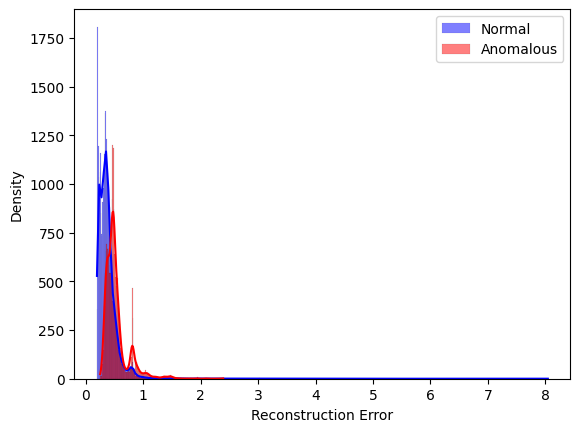


1028/1028 [==============================] - 3s 3ms/step


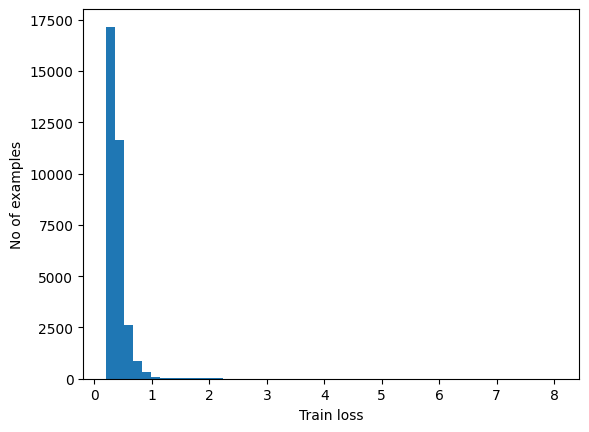

583/583 [==============================] - 2s 3ms/step



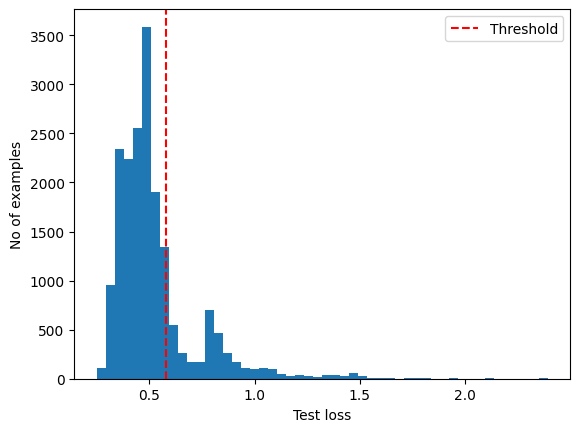

Threshold:  0.5799291


In [27]:
threshold = reconstruct_data(contractive_autoencoder, normal_test_data_wl_normalized, anomalous_test_data_wl_normalized)

In [28]:
prediction  = predict_anomaly(contractive_autoencoder, normal_test_data_wl_normalized[0], threshold)
print(f"The data instance is predicted as {prediction}.")

prediction_2  = predict_anomaly(contractive_autoencoder, anomalous_test_data_wl_normalized[9], threshold)
print(f"The data instance is predicted as {prediction}.")

The data instance is predicted as Normal.
The data instance is predicted as Normal.


In [29]:
preds = predict(contractive_autoencoder, normal_test_data_wl_normalized, threshold)
add_run_stats_to_file(contractive_autoencoder.name, preds, normal_test_data_labels, feature_analysis, normalisation,folder_path = "stats")

## 1.12 unsupervised Sparse Autoencoder implementation

In [30]:
class SparseAnomalyDetector(tf.keras.Model):
    def __init__(self, num_features, encoding_dim, sparsity_factor=1e-2):
        super(SparseAnomalyDetector, self).__init__(name='sparse_anomaly_detector')

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(num_features,)),
            layers.Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(sparsity_factor)),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(encoding_dim,)),
            layers.Dense(num_features, activation="sigmoid"),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

num_features = normal_train_data_wl_normalized.shape[1]
encoding_dim = 8  
sparsity_factor = 1e-2 

sparse_autoencoder = SparseAnomalyDetector(num_features=num_features, encoding_dim=encoding_dim, sparsity_factor=sparsity_factor)


In [31]:
sparse_autoencoder.compile(optimizer='adam', loss='mae')

In [32]:
sparse_autoencoder.build(input_shape=(None, normal_train_data_wl_normalized.shape[1]))
sparse_autoencoder.summary()

Model: "sparse_anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 8)                 352       
                                                                 
 sequential_3 (Sequential)   (None, 43)                387       
                                                                 
Total params: 739 (2.89 KB)
Trainable params: 739 (2.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history_sparse = train_model(sparse_autoencoder,normal_train_data_wl_normalized,normal_test_data_wl_normalized)

Epoch 1/100
129/129 [==============================] - 2s 6ms/step - loss: 0.4794 - val_loss: 0.4594
Epoch 2/100
129/129 [==============================] - 0s 4ms/step - loss: 0.4044 - val_loss: 0.3200
Epoch 3/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2346 - val_loss: 0.1680
Epoch 4/100
129/129 [==============================] - 0s 4ms/step - loss: 0.1320 - val_loss: 0.1061
Epoch 5/100
129/129 [==============================] - 0s 4ms/step - loss: 0.0929 - val_loss: 0.0824
Epoch 6/100
129/129 [==============================] - 1s 4ms/step - loss: 0.0770 - val_loss: 0.0718
Epoch 7/100
129/129 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0661
Epoch 8/100
129/129 [==============================] - 0s 4ms/step - loss: 0.0649 - val_loss: 0.0626
Epoch 9/100
129/129 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0599
Epoch 10/100
129/129 [==============================] - 0s 3ms/step - loss: 0.0595 - val_lo

In [34]:
plot_training_curve(history_sparse, sparse_autoencoder, feature_analysis, normalisation, epoch= EPOCH, directory = "training_plot_unsw")

In [35]:
reconstruct_sample(sparse_autoencoder, normal_test_data_wl_normalized.shape[1], normal_test_data_wl_normalized, anomalous_test_data_wl_normalized, "reconstruct_sample", feature_analysis, normalisation)

583/583 [==============================] - 1s 2ms/step


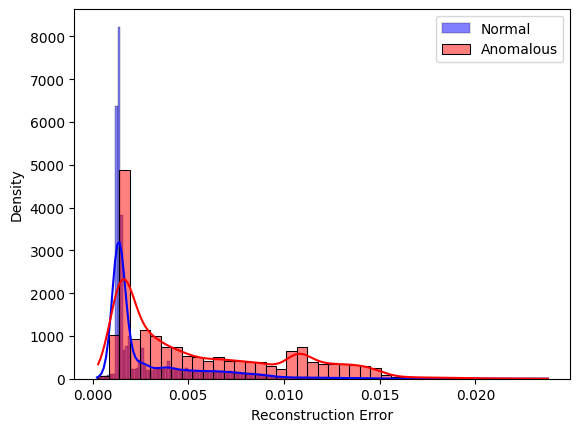


1028/1028 [==============================] - 2s 2ms/step


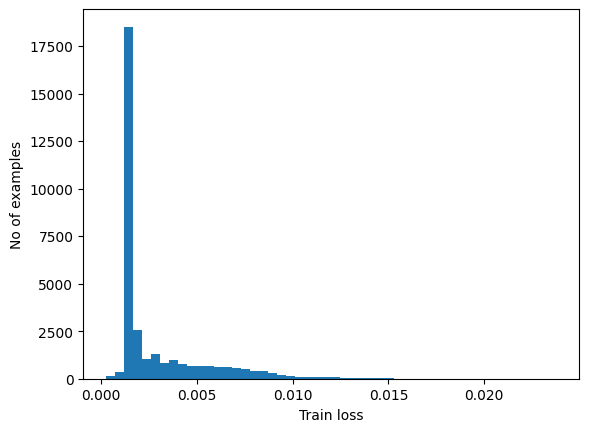

583/583 [==============================] - 1s 2ms/step



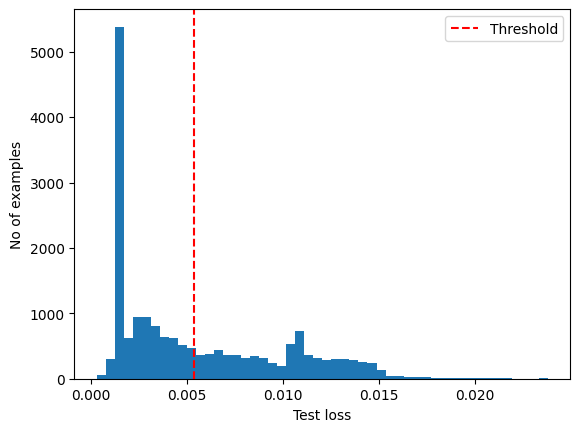

Threshold:  0.0053475364


In [36]:
threshold = reconstruct_data(sparse_autoencoder, normal_test_data_wl_normalized, anomalous_test_data_wl_normalized)

In [37]:
prediction  = predict_anomaly(sparse_autoencoder, normal_test_data_wl_normalized[0], threshold)
print(f"The data instance is predicted as {prediction}.")

The data instance is predicted as Normal.


In [44]:
preds = predict(sparse_autoencoder, normal_test_data_wl_normalized, threshold)
add_run_stats_to_file(sparse_autoencoder.name, preds, normal_test_data_labels, feature_analysis, normalisation,folder_path = "stats")

## 1.13 stats of all training with both autoencoders

In [41]:
display_stats_table(folder_path = "stats")

+------------------------------+--------------------+-----------------+------------+-------------+----------+
| Model                        | Feature Analysis   |   Normalization |   Accuracy |   Precision |   Recall |
+==============================+====================+=================+============+=============+==========+
| contractive_anomaly_detector | False              |               1 |   0.932409 |           1 | 0.932409 |
+------------------------------+--------------------+-----------------+------------+-------------+----------+
| sparse_anomaly_detector      | False              |               1 |   0.924564 |           1 | 0.924564 |
+------------------------------+--------------------+-----------------+------------+-------------+----------+
| contractive_anomaly_detector | False              |               2 |   0.972909 |           1 | 0.972909 |
+------------------------------+--------------------+-----------------+------------+-------------+----------+
| sparse_a

## 1.14 Plots training stats for contractive and sparse autoencoder

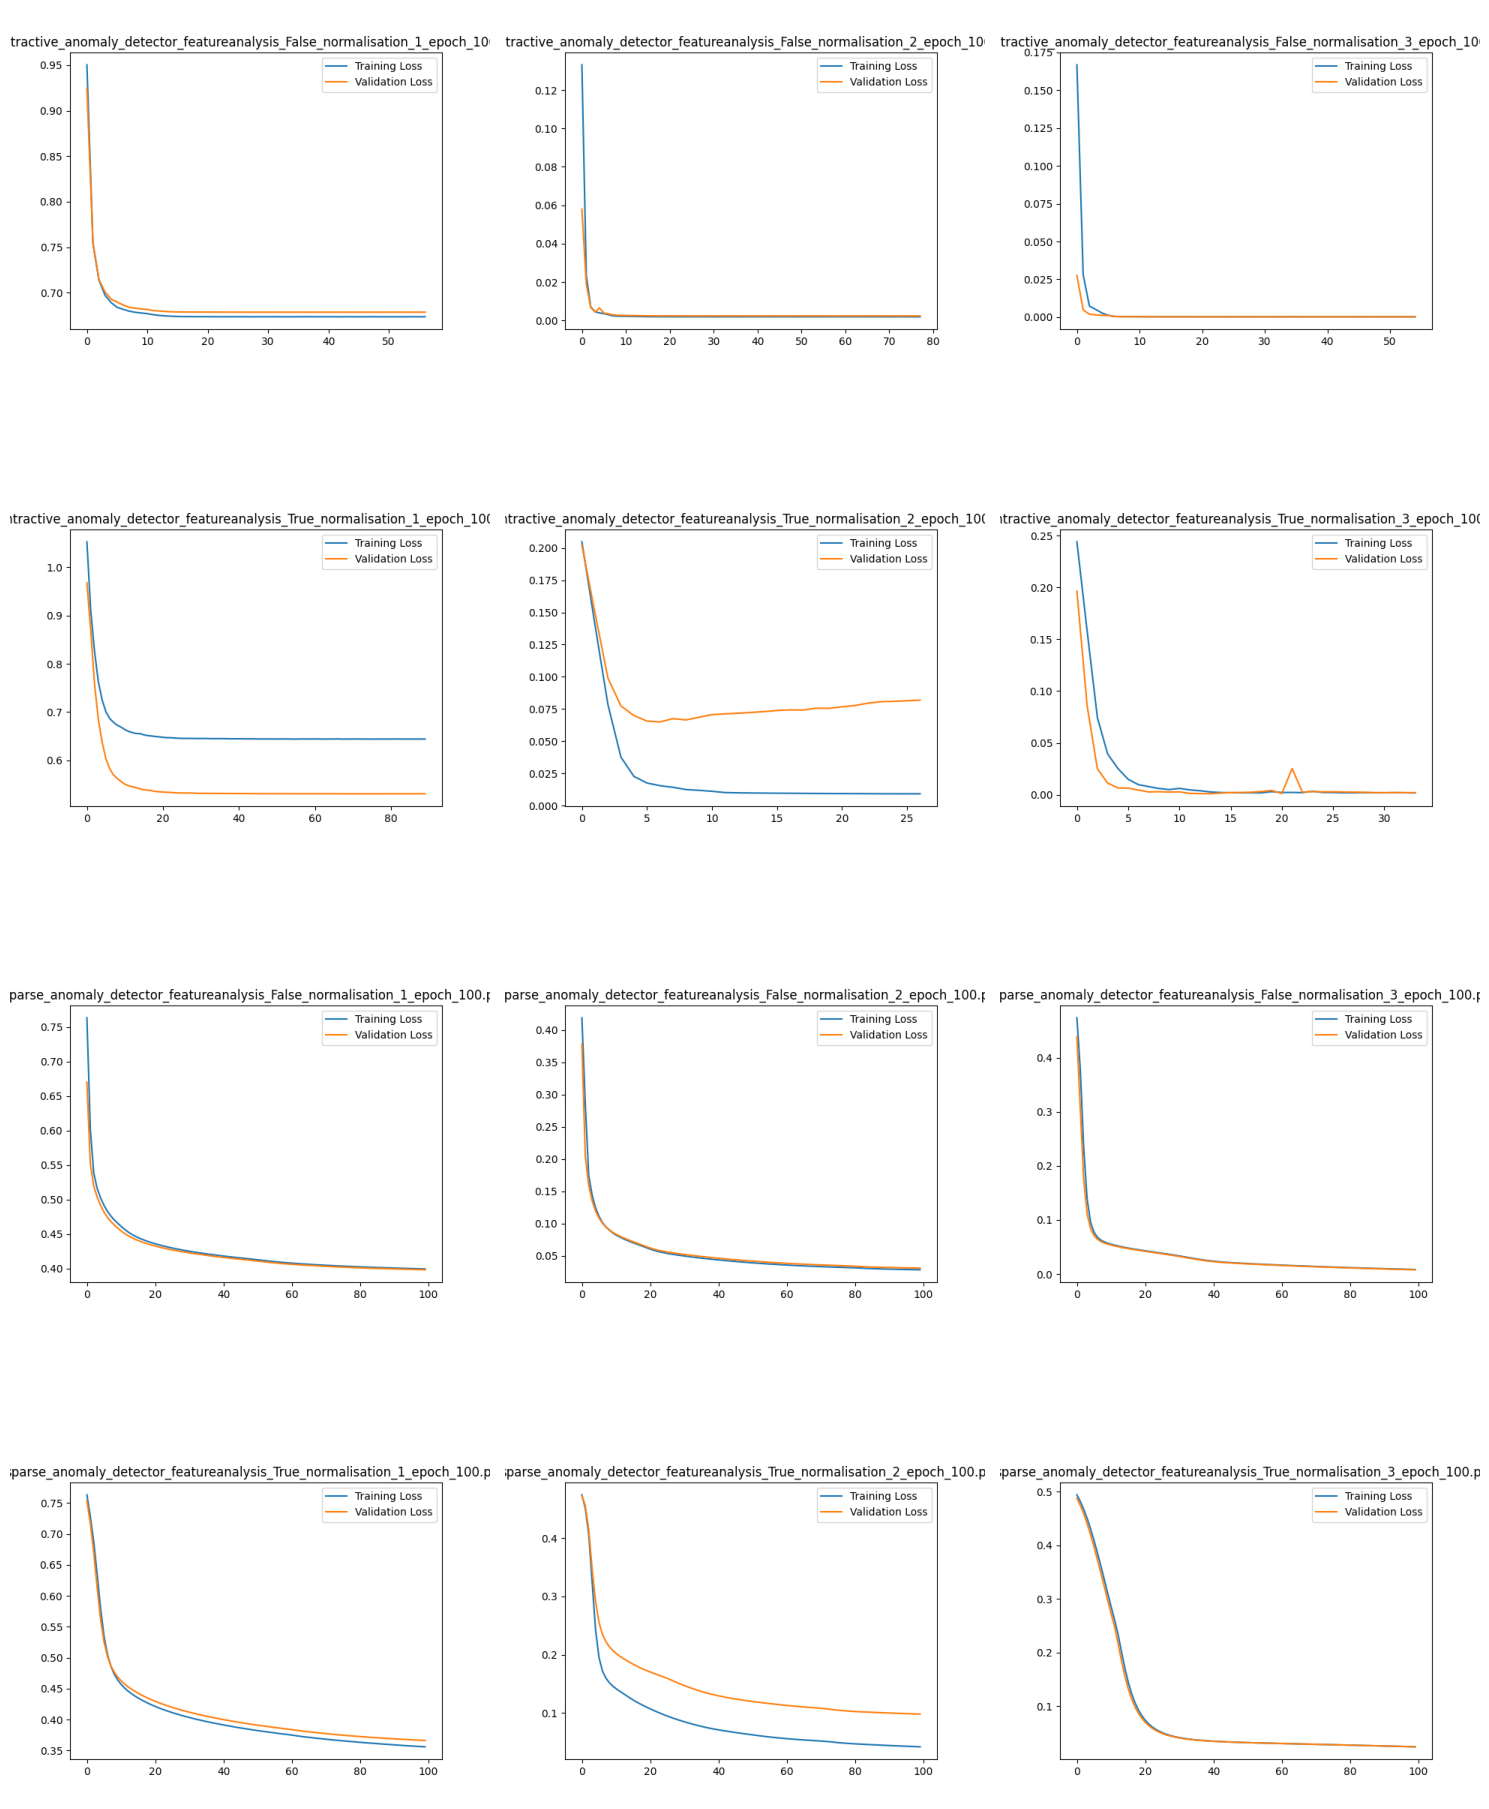

In [30]:
plot_images_in_folder('training_plot_unsw', images_per_row=3)

## 1.15 normal and anomalious sample reconstrcution with different normalisations

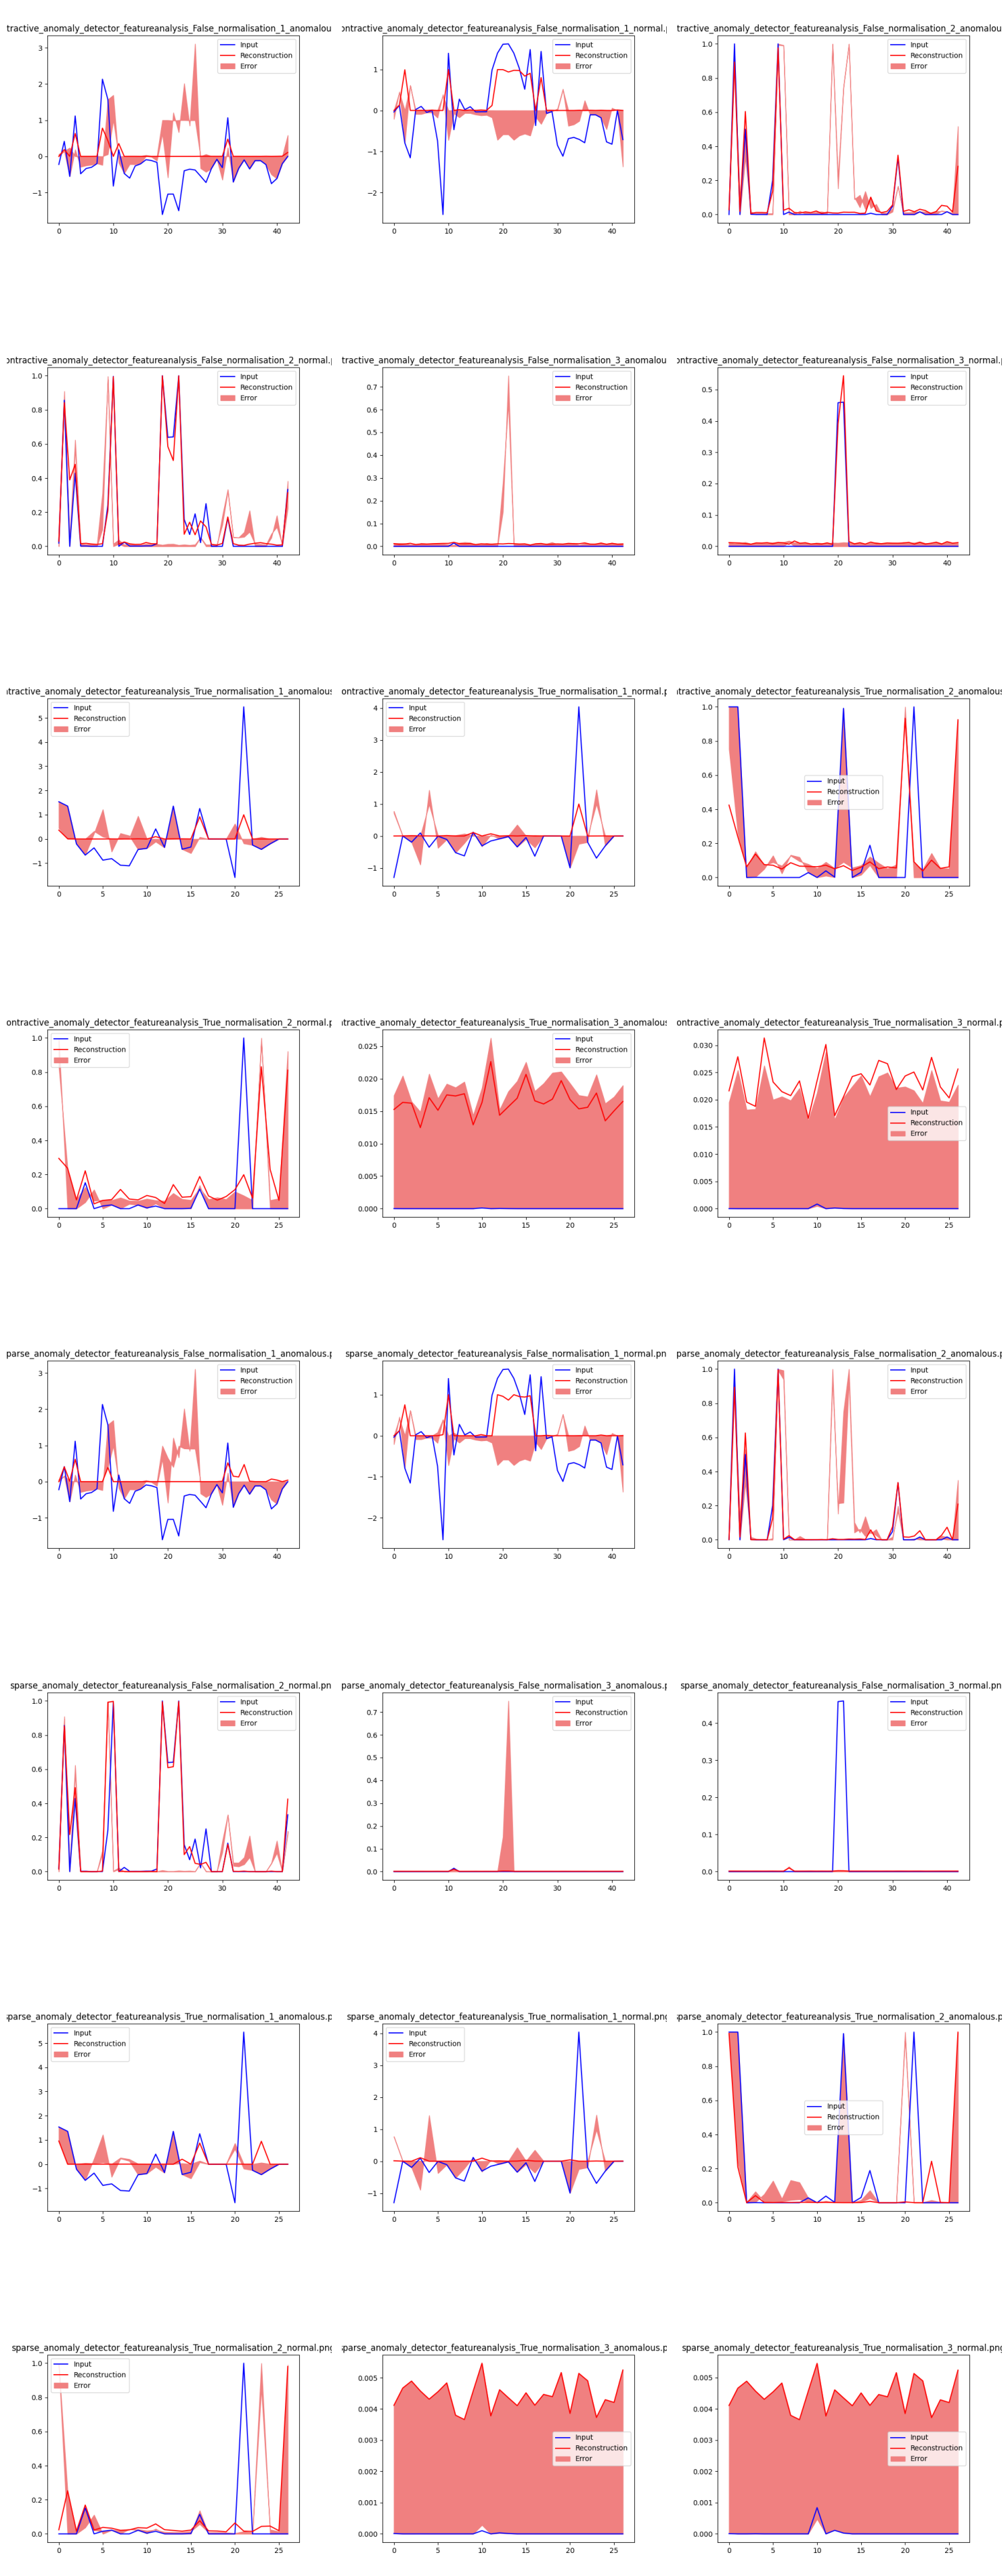

In [30]:
plot_images_in_folder('reconstruct_sample', images_per_row=3)

# 2.1 unsupervised LOF( Local Outlier Factor) 

In [34]:
dataframe

label  sttl  ct_state_ttl  ct_dst_sport_ltm        rate  \
29          0   254             1                 1   10.459041   
31          0   254             1                 1    8.834441   
32          0   254             1                 1    7.570899   
34          0   254             1                 1   11.603770   
35          0    62             1                 1   17.278635   
...       ...   ...           ...               ...         ...   
175248      1    62             1                 1  136.558356   
175267      1    62             1                 1   53.805315   
175277      1    62             1                 1  108.897021   
175305      1    62             1                 1   31.468251   
175337      1   254             1                 1   33.612649   

        ct_src_dport_ltm  ct_dst_src_ltm  ct_src_ltm  ct_srv_dst  ct_srv_src  \
29                     1               1           1           1           2   
31                     1               1           1           1           2   
32                     1               1           2           1           1   
34                     1               3           2           2           4   
35                     1               2           1           3           2   
...                  ...             ...         ...         ...         ...   
175248                 1               1          18           1           1   
175267                 1               1          18           1           1   
175277                 1               1           2           1           1   
175305                 1               2           2           1           1   
175337                 1               2           1           1           1   

        ...  proto_arp  proto_tcp  proto_udp  service_-  service_ftp  \
29      ...        0.0        1.0        0.0        1.0          0.0   
31      ...        0.0        1.0        0.0        1.0          0.0   
32      ...        0.0        1.0        0.0        1.0          0.0   
34      ...        0.0        1.0        0.0        1.0          0.0   
35      ...        0.0        1.0        0.0        0.0          0.0   
...     ...        ...        ...        ...        ...          ...   
175248  ...        0.0        1.0        0.0        0.0          0.0   
175267  ...        0.0        1.0        0.0        0.0          0.0   
175277  ...        0.0        1.0        0.0        1.0          0.0   
175305  ...        0.0        1.0        0.0        0.0          0.0   
175337  ...        0.0        1.0        0.0        1.0          0.0   

        service_ftp-data  service_http  service_smtp  state_ACC  state_FIN  
29                   0.0           0.0           0.0        0.0        1.0  
31                   0.0           0.0           0.0        0.0        1.0  
32                   0.0           0.0           0.0        0.0        1.0  
34                   0.0           0.0           0.0        0.0        1.0  
35                   0.0           1.0           0.0        0.0        1.0  
...                  ...           ...           ...        ...        ...  
175248               0.0           0.0           1.0        0.0        1.0  
175267               0.0           0.0           1.0        0.0        1.0  
175277               0.0           0.0           0.0        0.0        1.0  
175305               0.0           0.0           1.0        0.0        1.0  
175337               0.0           0.0           0.0        0.0        1.0  

[113977 rows x 28 columns]

In [35]:
dataframe.shape

(113977, 28)

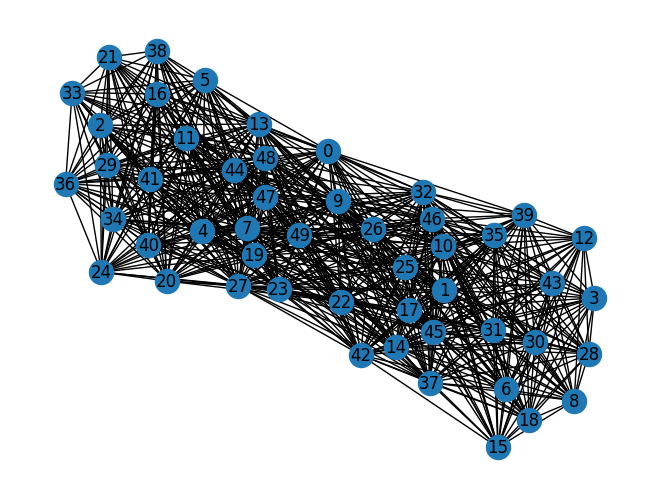


Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68     12099
           1       0.46      0.05      0.09     10697

    accuracy                           0.53     22796
   macro avg       0.50      0.50      0.38     22796
weighted avg       0.50      0.53      0.40     22796



In [36]:
df = dataframe
y_true = dataframe['label']
X = df.iloc[:, 1:]  # Features
n_neighbors=20


X_train, X_test, y_true_train, y_true_test = train_test_split(X, y_true, test_size=0.2, random_state=42)

lof = LocalOutlierFactor(n_neighbors, contamination=0.05) 
y_pred_train = lof.fit_predict(X_train)

y_pred_binary_train = np.where(y_pred_train == -1, 1, 0)



y_pred_test = lof.fit_predict(X_test)

y_pred_binary_test = np.where(y_pred_test == -1, 1, 0)



sample_size = 50
sampled_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
sampled_graph = kneighbors_graph(X_train.iloc[sampled_indices], n_neighbors)

dense_sampled_graph = sampled_graph.toarray()

G = nx.Graph(dense_sampled_graph)

nx.draw(G, with_labels=True)
plt.show()

classification_rep_test = classification_report(y_true_test, y_pred_binary_test)
print("\nClassification Report for Test Data:\n", classification_rep_test)

In [37]:
original_data_point_index = 32

corresponding_datapoint = X_train.iloc[original_data_point_index]

is_anomaly = y_pred_binary_train[sampled_indices[original_data_point_index]] == 1

print(f"Corresponding Datapoint for Graph Point {original_data_point_index}:\n{corresponding_datapoint}")
print(f"Is Anomaly: {is_anomaly}")


Corresponding Datapoint for Graph Point 32:
sttl                 254.000000
ct_state_ttl           1.000000
ct_dst_sport_ltm       1.000000
rate                  18.086955
ct_src_dport_ltm       1.000000
ct_dst_src_ltm         3.000000
ct_src_ltm             2.000000
ct_srv_dst             3.000000
ct_srv_src             4.000000
ct_dst_ltm             1.000000
sload               4639.906738
dur                    0.829327
sbytes               534.000000
dttl                 252.000000
trans_depth            0.000000
sloss                  2.000000
ackdat                 0.038563
proto_arp              0.000000
proto_tcp              1.000000
proto_udp              0.000000
service_-              1.000000
service_ftp            0.000000
service_ftp-data       0.000000
service_http           0.000000
service_smtp           0.000000
state_ACC              0.000000
state_FIN              1.000000
Name: 81362, dtype: float64
Is Anomaly: False


# 2.2 unsupervised clustering with Isolation Forest

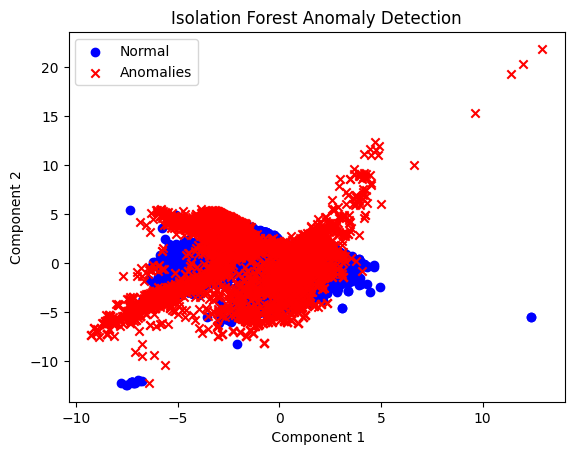

Accuracy: 0.5111557594953368
Precision: 0.3591858220740481
Recall: 0.03782894736842105
F1-score: 0.06844894751801507


In [45]:
X = dataframe.iloc[:, 1:] 
y_true = dataframe['label'] 

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

iso_forest = IsolationForest(contamination=0.05, random_state=42) 
iso_forest.fit(X_std)

y_pred = iso_forest.fit_predict(X_std)

y_pred_binary = (y_pred == -1).astype(int)

y_pred[y_pred == 1] = 0  
y_pred[y_pred == -1] = 1  

plt.scatter(X_pca[y_pred == 0, 0], X_pca[y_pred == 0, 1], c='blue', label='Normal')
plt.scatter(X_pca[y_pred == 1, 0], X_pca[y_pred == 1, 1], c='red', marker='x', label='Anomalies')

plt.title('Isolation Forest Anomaly Detection')
plt.xlabel(' Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()


precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
accuracy = accuracy_score(y_true, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [46]:
dataframe.insert(1, 'predicted_label', y_pred_binary)
dataframe.sample(10)

label  predicted_label  sttl  ct_state_ttl  ct_dst_sport_ltm  \
19037       0                0    31             0                 1   
118698      1                0   254             1                 1   
10314       0                0    31             0                 1   
48821       1                0   254             1                 1   
146314      1                0   254             1                 1   
120712      1                0    62             1                 1   
47356       1                0   254             1                 1   
24172       0                0    31             0                 1   
116050      1                0    62             1                 1   
76683       0                0   254             1                 1   

                rate  ct_src_dport_ltm  ct_dst_src_ltm  ct_src_ltm  \
19037    1402.947396                 1               5           4   
118698     24.021715                 1               6           2   
10314    3292.705116                 1               1           2   
48821      34.697135                 2               7           2   
146314     39.154002                 1               2           3   
120712      7.826639                 1               2           2   
47356      15.429101                 1               1           1   
24172   11314.395860                 1               1           2   
116050     27.522609                 1               1           1   
76683      45.180170                 1               2           1   

        ct_srv_dst  ...  proto_arp  proto_tcp  proto_udp  service_-  \
19037            8  ...        0.0        1.0        0.0        1.0   
118698           5  ...        0.0        1.0        0.0        1.0   
10314           11  ...        0.0        1.0        0.0        1.0   
48821            7  ...        0.0        1.0        0.0        1.0   
146314           3  ...        0.0        1.0        0.0        1.0   
120712           1  ...        0.0        1.0        0.0        0.0   
47356            2  ...        0.0        1.0        0.0        1.0   
24172            5  ...        0.0        1.0        0.0        1.0   
116050           1  ...        0.0        1.0        0.0        0.0   
76683            2  ...        0.0        1.0        0.0        1.0   

        service_ftp  service_ftp-data  service_http  service_smtp  state_ACC  \
19037           0.0               0.0           0.0           0.0        0.0   
118698          0.0               0.0           0.0           0.0        0.0   
10314           0.0               0.0           0.0           0.0        0.0   
48821           0.0               0.0           0.0           0.0        0.0   
146314          0.0               0.0           0.0           0.0        0.0   
120712          0.0               1.0           0.0           0.0        0.0   
47356           0.0               0.0           0.0           0.0        0.0   
24172           0.0               0.0           0.0           0.0        0.0   
116050          0.0               0.0           1.0           0.0        0.0   
76683           0.0               0.0           0.0           0.0        0.0   

        state_FIN  
19037         1.0  
118698        1.0  
10314         1.0  
48821         1.0  
146314        1.0  
120712        1.0  
47356         1.0  
24172         1.0  
116050        1.0  
76683         1.0  

[10 rows x 29 columns]

# 3. Timeseries Dataset

In [21]:
from credit_card_data_preperation import data_preparation, extract_time_interval_df

## 3.1 method to plot reconstructed data 

In [22]:
def reconstruction_data(model, train_data, anomalous_data ):
    x_train_pred = sparse_conv_autoencoder.predict(train_data)
    train_mae_loss = np.mean(np.abs(x_train_pred - train_data), axis=1)
    
    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()
    
    threshold_sparse = np.max(train_mae_loss)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_data[0])
    plt.title('Original Data')
    
    plt.subplot(1, 2, 2)
    plt.plot(x_train_pred[0])
    plt.title('Predicted sparse Data')
    
    plt.show()
    
    # Get train MAE loss.
    x_anomalies_pred = sparse_conv_autoencoder.predict(anomalous_data)
    anomalies_mae_loss = np.mean(np.abs(x_anomalies_pred - anomalous_data), axis=1)
    
    plt.hist(anomalies_mae_loss, bins=50)
    plt.xlabel("anaomalious MAE loss")
    plt.ylabel("No of samples")
    plt.show()
    
    plt.figure(figsize=(12, 4))
    
    # Subplot for original data
    plt.subplot(1, 2, 1)
    plt.plot(anomalous_data[0])
    plt.title('Original anamalious Data')
    
    # Subplot for predicted data
    plt.subplot(1, 2, 2)
    plt.plot(x_anomalies_pred[0])
    plt.title('Predicted anomalious Data')    
    plt.show()
    print("Reconstruction error threshold: ", threshold_sparse)


## 3.2 method for anamaly prediction

In [23]:
def predict_anomalies(model, time_interval_data): 
    
    global global_threshold 
    batch_size = 32  
    anomaly_scores = model.predict(time_interval_data, batch_size=batch_size)   
    
    plt.figure(figsize=(12, 4))
    loss = tf.keras.losses.mae(model(time_interval_data), time_interval_data)
    
    mean_loss = np.mean(loss)
    std_loss = np.std(loss)
    threshold_multiplier = 2  # Adjust the multiplier
    global_threshold = mean_loss + threshold_multiplier * std_loss

    # Subplot for original data
    plt.subplot(1, 2, 1)
    plt.plot(interval_data[0])
    plt.title('Original range Data')
    
    # Subplot for predicted data
    plt.subplot(1, 2, 2)
    plt.plot(anomaly_scores[0])
    plt.title('Predicted range Data')
    
    plt.show()
    #print(anomalies)
    return tf.math.less(global_threshold, loss)


## 3.3 Data preparation and normalisation

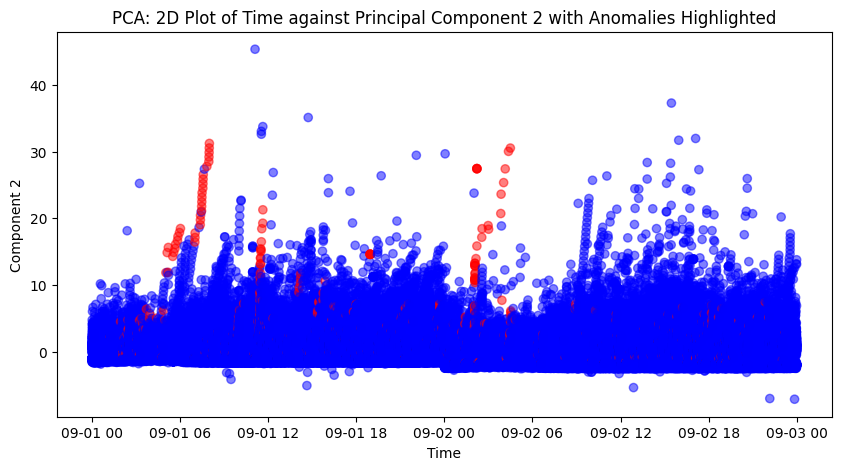

Normalizing using MinMaxScaler


In [24]:
normalisation = 2
X_train_scaled, X_test_scaled, x_anomalies_scaled, input_shape = data_preparation(sequence_length= 12, normalization=normalisation)  

## 3.4 setting time interval for prediction

In [25]:
start_time = pd.to_datetime('2013-09-01 00:00:01')
end_time = pd.to_datetime('2013-09-01 00:51:19')

interval_data , interval_labels_data = extract_time_interval_df( start_time, end_time, sequence_length =input_shape[0], normalisation = normalisation)


Normalisation 2


In [26]:
interval_data.shape


(3588, 12, 30)

In [27]:
interval_labels_data.shape

(3588, 12)

## 3.5 Sparse convolutional Autoencoder implementation

In [28]:
sparsity_factor = 1e-7
filters = 32
kernel_size = 3

In [29]:
class SparseConvAutoencoder(tf.keras.Model):
    def __init__(self, filters, kernel_size, input_shape, sparsity_factor):
        super(SparseConvAutoencoder, self).__init__(name = "sparse_conv_autoencoder")

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", strides=2, activation="relu",
                          activity_regularizer=regularizers.l1(sparsity_factor)),
            layers.Conv1D(filters=filters // 2, kernel_size=kernel_size, padding="same", strides=2, activation="relu",
                          activity_regularizer=regularizers.l1(sparsity_factor)),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(filters=filters // 2, kernel_size=kernel_size, padding="same", strides=2, activation="relu",
                                   activity_regularizer=regularizers.l1(sparsity_factor)),
            layers.Conv1DTranspose(filters=filters, kernel_size=kernel_size, padding="same", strides=2, activation="relu",
                                   activity_regularizer=regularizers.l1(sparsity_factor)),
            layers.Conv1DTranspose(input_shape[1], kernel_size=kernel_size, padding="same"),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [30]:
sparse_conv_autoencoder = SparseConvAutoencoder(filters=filters, kernel_size=kernel_size,
                                                input_shape=input_shape, sparsity_factor=sparsity_factor)
sparse_conv_autoencoder.build((None,) + input_shape)

sparse_conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
sparse_conv_autoencoder.summary()



Model: "sparse_conv_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3, 16)             4464      
                                                                 
 sequential_1 (Sequential)   (None, 12, 30)            5262      
                                                                 
Total params: 9726 (37.99 KB)
Trainable params: 9726 (37.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history_sparse_convolutional = train_model(sparse_conv_autoencoder,X_train_scaled,X_test_scaled)

Epoch 1/100

223/223 [==============================] - 8s 27ms/step - loss: 0.2042 - val_loss: 0.0635
Epoch 2/100
223/223 [==============================] - 6s 26ms/step - loss: 0.0291 - val_loss: 0.0126
Epoch 3/100
223/223 [==============================] - 6s 25ms/step - loss: 0.0090 - val_loss: 0.0069
Epoch 4/100
223/223 [==============================] - 6s 26ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 5/100
223/223 [==============================] - 5s 24ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 6/100
223/223 [==============================] - 6s 26ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/100
223/223 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/100
223/223 [==============================] - 6s 27ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/100
223/223 [==============================] - 5s 24ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/100
223/223 [==============================] - 6s 26ms/step - loss: 0.00

In [32]:
plot_training_curve(history_sparse_convolutional, sparse_conv_autoencoder, feature_analysis, normalisation, epoch= EPOCH,  directory = "training_plot_creditcard")

7108/7108 [==============================] - 23s 3ms/step


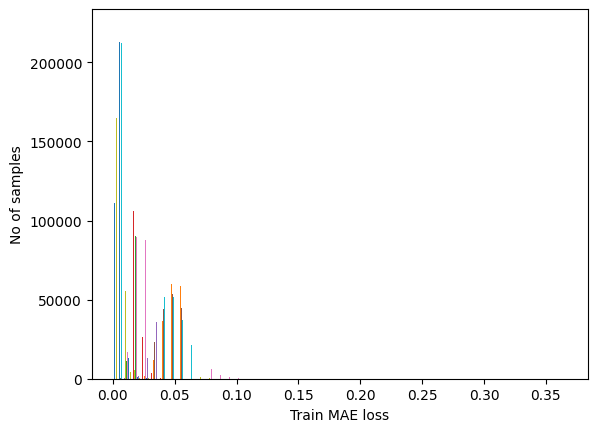

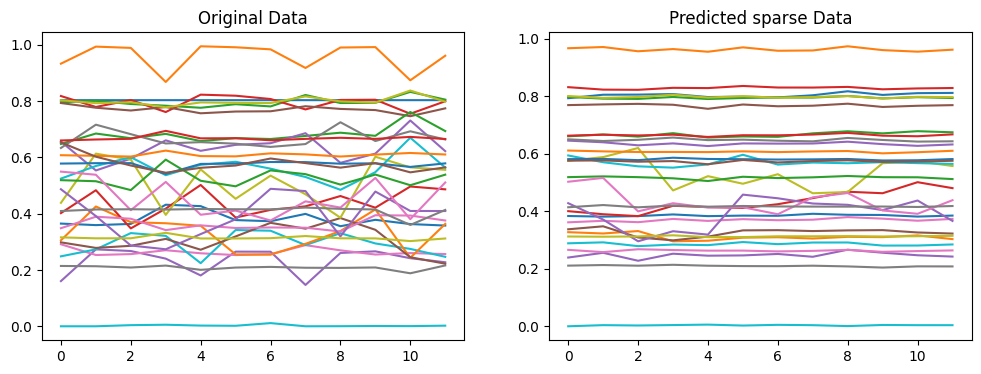

16/16 [==============================] - 0s 12ms/step


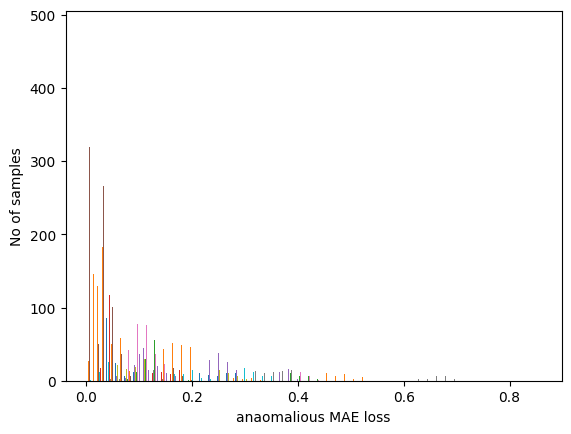

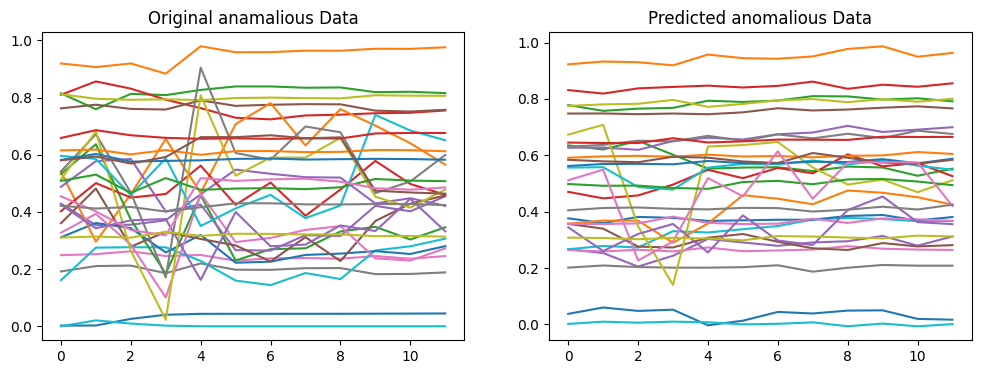

Reconstruction error threshold:  0.36643456484607656


In [33]:
reconstruction_data(sparse_conv_autoencoder, X_train_scaled,x_anomalies_scaled)

## 3.6 contractive convolutional Autoencoder implementation

In [34]:
class ContractiveConvAnomalyDetector(tf.keras.Model):
    def __init__(self, lam):
        super(ContractiveConvAnomalyDetector, self).__init__(name = "contractive_conv_anomaly_detector")
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1D(filters=8, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization()
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(filters=8, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=30, kernel_size=3, activation="sigmoid", padding="same"), 
        ])
        self.lam = lam  # Regularization strength of autoencoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def compute_jacobian(self, x):
        x = tf.convert_to_tensor(x)  
    
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            encoded = self.encoder(x)
    
        jacobian = tape.jacobian(encoded, x)
        
        return jacobian

    def contractive_loss(self, x, x_hat, jacobian):
        mse_loss = tf.reduce_mean(tf.square(x - x_hat))
        squared_jacobian = tf.square(jacobian)
        frobenius_norm = tf.sqrt(tf.reduce_sum(squared_jacobian))        
        total_loss = mse_loss + self.lam * frobenius_norm
        return total_loss   

In [35]:
 def train_step(self, data):
        x, _ = data
        with tf.GradientTape() as tape:
            x_hat = self(x)
            jacobian = self.compute_jacobian(x)
            loss = self.contractive_loss(x, x_hat, jacobian)
            
        gradients = tape.gradient(loss, self.trainable_variables)
       
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)        
        self.optimizer.apply_gradients(zip(clipped_gradients, self.trainable_variables))

        return {"loss": loss}

In [36]:
contractive_convolutional_autoencoder = ContractiveConvAnomalyDetector(lam=1e-8)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.09,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

contractive_convolutional_autoencoder.compile(optimizer=optimizer, loss='mse')


In [37]:
contractive_convolutional_autoencoder.build((None,) + input_shape)
contractive_convolutional_autoencoder.summary()

Model: "contractive_conv_anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 12, 8)             17848     
                                                                 
 sequential_3 (Sequential)   (None, 12, 30)            14646     
                                                                 
Total params: 32494 (126.93 KB)
Trainable params: 31950 (124.80 KB)
Non-trainable params: 544 (2.12 KB)
_________________________________________________________________


In [38]:
history_convolutional_contractive = train_model(contractive_convolutional_autoencoder, X_train_scaled, X_test_scaled)

Epoch 1/100
223/223 [==============================] - 29s 101ms/step - loss: 0.0560 - val_loss: 0.0243
Epoch 2/100
223/223 [==============================] - 22s 98ms/step - loss: 0.0152 - val_loss: 0.0074
Epoch 3/100
223/223 [==============================] - 22s 98ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 4/100
223/223 [==============================] - 22s 97ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/100
223/223 [==============================] - 21s 96ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/100
223/223 [==============================] - 22s 97ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/100
223/223 [==============================] - 22s 98ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/100
223/223 [==============================] - 22s 98ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/100
223/223 [==============================] - 22s 99ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/100
223/223 [==============================] - 22s 97ms/step - 

In [39]:
plot_training_curve(history_convolutional_contractive, contractive_convolutional_autoencoder, feature_analysis, normalisation, epoch= EPOCH, directory = "training_plot_creditcard")

7108/7108 [==============================] - 24s 3ms/step


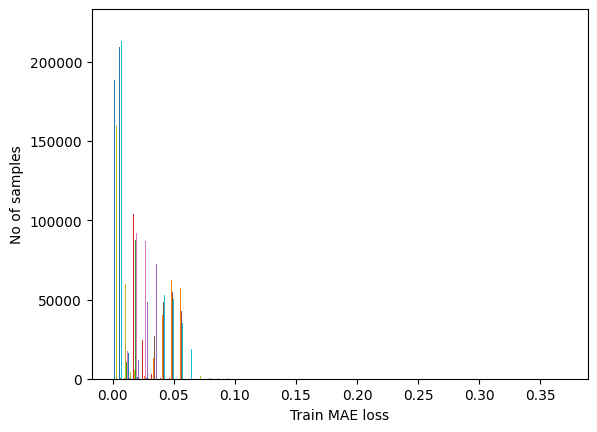

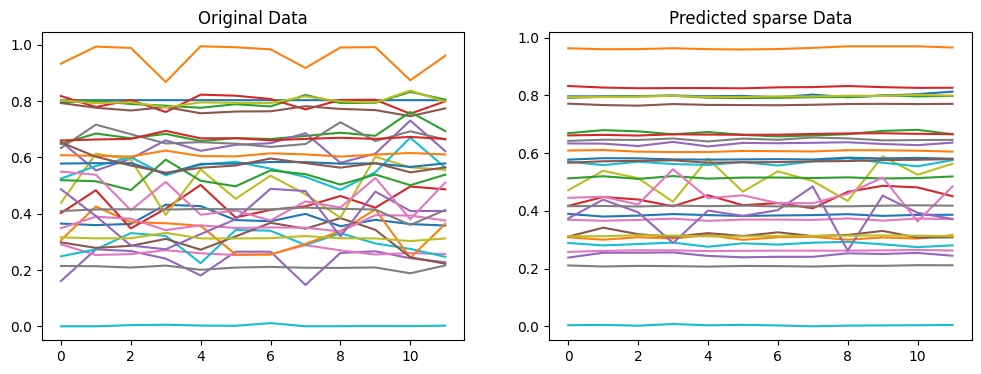

16/16 [==============================] - 0s 5ms/step


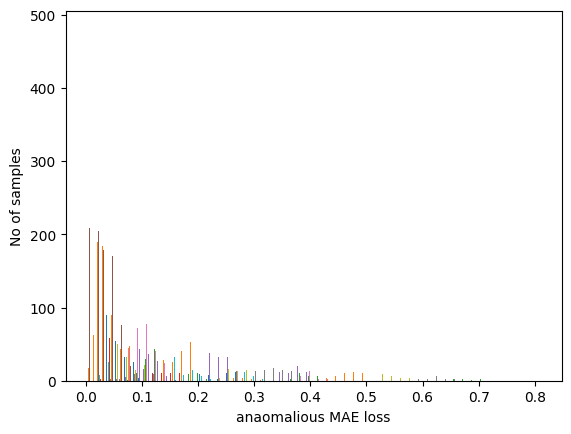

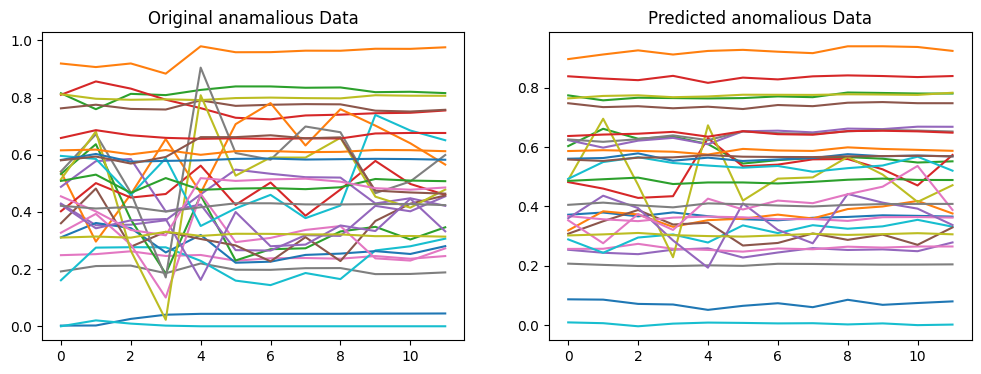

Reconstruction error threshold:  0.3714739661984821


In [42]:
reconstruction_data(contractive_convolutional_autoencoder, X_train_scaled, x_anomalies_scaled)

## 3.7 contractive convolutional autoencoder reconstruction for interval instance

113/113 [==============================] - 1s 6ms/step


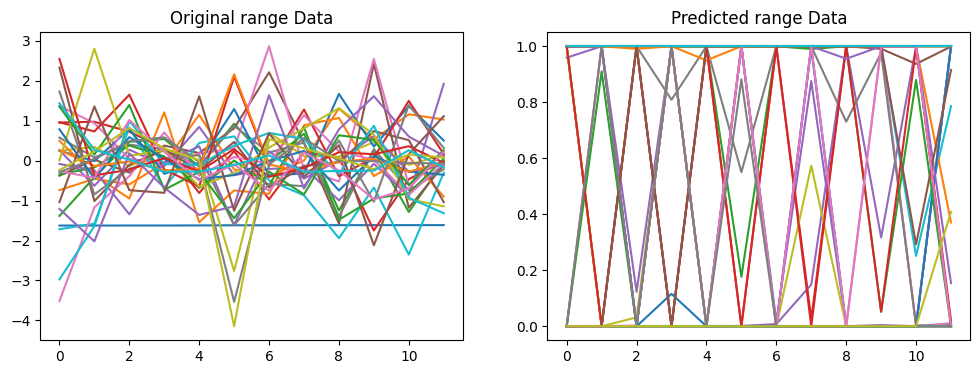

In [43]:
preds = predict_anomalies(contractive_convolutional_autoencoder, interval_data)
add_run_stats_to_file(contractive_convolutional_autoencoder.name, preds, interval_labels_data, feature_analysis, normalization,folder_path = "stats_credit_card")

## 3.8 sparse contractive autoencoder reconstruction for interval instance

113/113 [==============================] - 0s 3ms/step


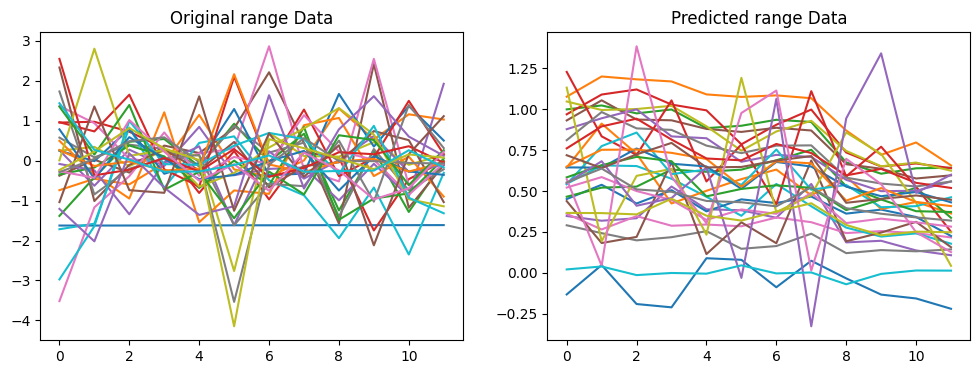

In [44]:
preds = predict_anomalies(sparse_conv_autoencoder, interval_data)
add_run_stats_to_file(sparse_conv_autoencoder.name, preds, interval_labels_data, feature_analysis, normalization, folder_path = "stats_credit_card")

## 3.9 plot alll training results

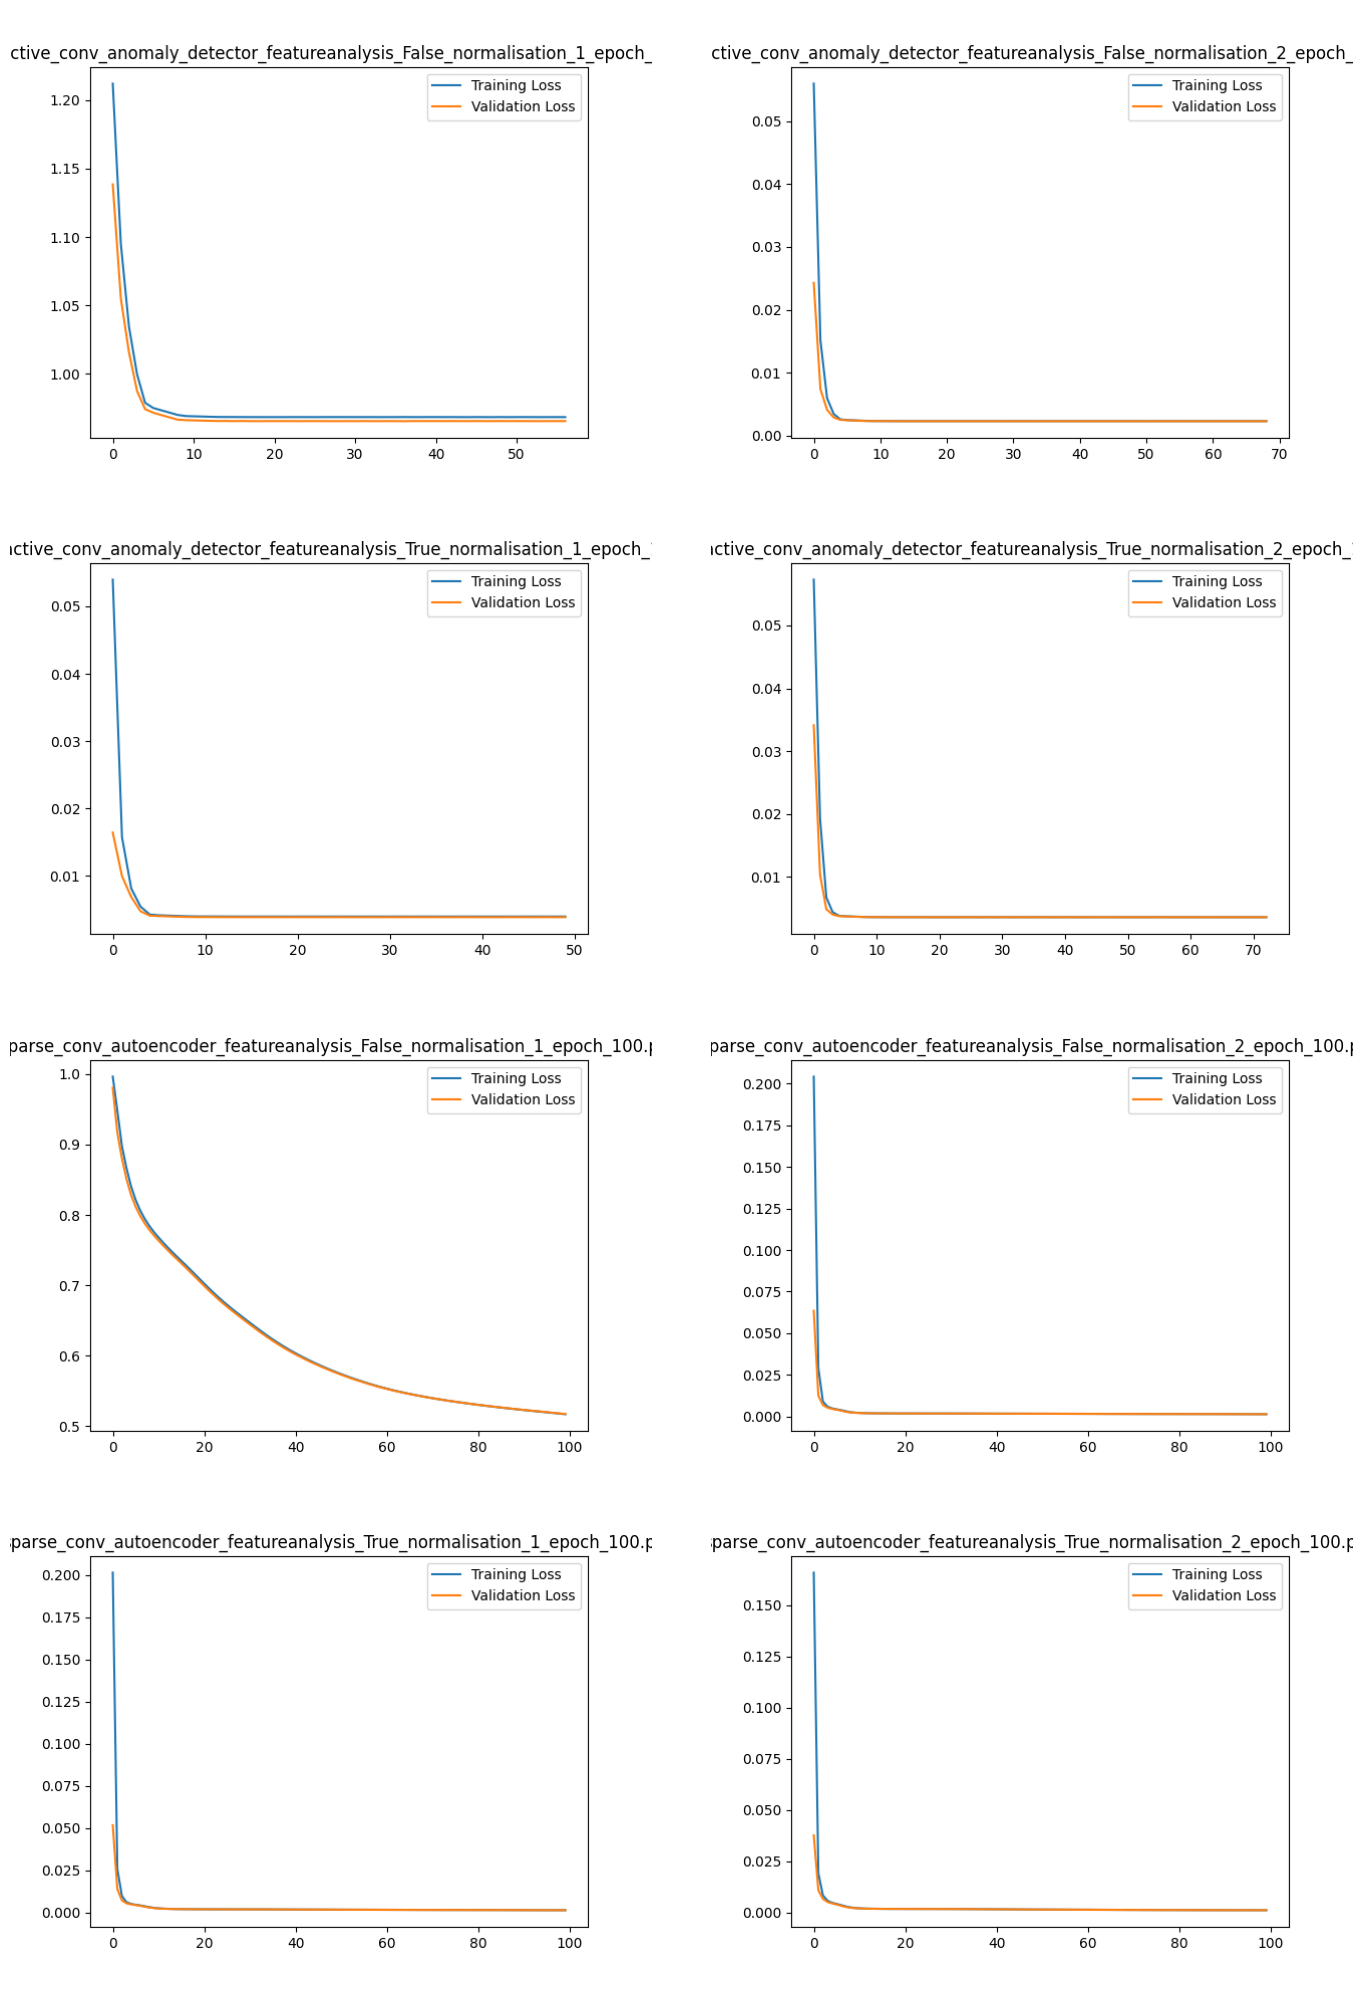

In [40]:
plot_images_in_folder('training_plot_creditcard', images_per_row=2)

## 3.10 display all moel Stats results

In [45]:
display_stats_table(folder_path = "stats_credit_card")

+-----------------------------------+--------------------+-----------------+------------+-------------+----------+
| Model                             | Feature Analysis   |   Normalization |   Accuracy |   Precision |   Recall |
+===================================+====================+=================+============+=============+==========+
| contractive_conv_anomaly_detector | False              |               1 |   0.743032 |  0.01       | 0.5      |
+-----------------------------------+--------------------+-----------------+------------+-------------+----------+
| sparse_conv_autoencoder           | False              |               1 |   0.700948 |  0.00810263 | 0.5      |
+-----------------------------------+--------------------+-----------------+------------+-------------+----------+
| contractive_conv_anomaly_detector | False              |               2 |   0.757525 |  0.0104257  | 0.5      |
+-----------------------------------+--------------------+-----------------+----